In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LassoCV, LinearRegression, MultiTaskLassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
import seaborn as sns

from Scripts.keras_model import *
from hyperopt import hp, fmin, tpe, STATUS_OK, STATUS_FAIL, Trials, space_eval
import hyperopt.pyll.stochastic
from hyperopt.pyll import scope
from functools import partial
from tensorflow.keras.callbacks import EarlyStopping

import copy

from IPython.display import clear_output

import pickle
import os
import random
import json

2021-09-14 13:47:03.266327: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# Standard stuff

In [2]:
datapath = Path('Data')

In [3]:
#function to read WRI data
def read_reservoir_data(name):
    WL = pd.read_csv(datapath / 'Waterlevel' / (name+'.csv'), index_col='FLOW_DATE', parse_dates=True)
    WL = WL.loc[:, ['PRESENT_STORAGE_TMC', 'RES_LEVEL_FT', 'INFLOW_CUSECS', 'OUTFLOW_CUECS']]
    for c in WL.columns:
        WL.loc[:, c] = pd.to_numeric(WL.loc[:,c], errors='coerce')
        
    WL.columns = ['Storage', 'Level', 'Inflow', 'Outflow']
    
    #TMC to m3
    WL.Storage = WL.Storage * 28316846.59
    
    #CUSECS to m3/s
    WL.Inflow = WL.Inflow * 0.028316847
    WL.Outflow = WL.Outflow * 0.028316847
    WL = WL.sort_index().astype(np.float64)
    WL = WL[~WL.index.duplicated(keep='first')]
    
    ind = pd.date_range(WL.index[0], WL.index[-1], freq='1D')
    WL_ = pd.DataFrame(index = ind, columns = WL.columns)
    for c in WL_.columns:
        WL_.loc[WL_.index.isin(WL.index), c] = pd.to_numeric(WL.loc[:,c], errors='coerce')
    
    return WL_.astype(np.float64).interpolate(method='time')

Reservoir data

In [4]:
reservoirs = ['Harangi', 'Hemavathi', 'Kabini', 'KRS']

reservoir_data = {r: read_reservoir_data(r) for r in reservoirs}

In [10]:
index = ['Outflow','Inflow','Storage','evap','evap_per']
waterbalans = pd.DataFrame(index=index, columns=reservoirs)
verdamping_script_nils = [32595.191548, 42648.480338, 177917.704077,290252.228846]
 
for i,reservoir in enumerate(reservoirs):
    waterbalans[reservoir]['Outflow'] = reservoir_data[reservoir]['Outflow'].resample('Y').sum().mean()*60*60*24
    waterbalans[reservoir]['Inflow'] = reservoir_data[reservoir]['Inflow'].resample('Y').sum().mean()*60*60*24
    waterbalans[reservoir]['Storage'] = reservoir_data[reservoir]['Storage'].resample('Y').mean().mean()*60*60*24
    waterbalans[reservoir]['evap'] = verdamping_script_nils[i]/10000
    waterbalans[reservoir]['evap_per'] = verdamping_script_nils[i]/(reservoir_data[reservoir]['Inflow'].resample('Y').sum().mean()*60*60*24)*100

# "{:.2E}".format(waterbalans)
# print("{0:.2E}".format(waterbalans))
waterbalans

,Harangi,Hemavathi,Kabini,KRS
Outflow,993102008.171207,2048758667.006638,2304858357.530046,3860813034.882392
Inflow,995294056.551035,1975479992.440766,2421751112.528662,3829169804.776192
Storage,10387745331890.349609,42789789530055.695312,31344840190162.746094,70613556039123.9375
evap,3.259519,4.264848,17.79177,29.025223
evap_per,0.003275,0.002159,0.007347,0.00758


In [12]:
#relation KRS vs Harangi and Hemavati

KRS_reservoir = reservoir_data['KRS']
KRS_reservoir = KRS_reservoir.rename(columns = {'Outflow': 'Outflow_KRS','Inflow': 'Inflow_KRS'}, inplace = False)
KRS_reservoir = KRS_reservoir.join(reservoir_data['Harangi']['Outflow'], how='left')
KRS_reservoir = KRS_reservoir.rename(columns = {'Outflow': 'Outflow_Harangi'}, inplace = False)
KRS_reservoir = KRS_reservoir.join(reservoir_data['Hemavathi']['Outflow'], how='left')
KRS_reservoir = KRS_reservoir.rename(columns = {'Outflow': 'Outflow_Hemavathi'}, inplace = False)
KRS_reservoir['nat_outflow_up_reservoirs'] = KRS_reservoir['Outflow_Harangi']+KRS_reservoir['Outflow_Hemavathi']
KRS_reservoir['nat_inflow_KRS'] = KRS_reservoir['Inflow_KRS']-KRS_reservoir['Outflow_Harangi']-KRS_reservoir['Outflow_Hemavathi']
KRS_reservoir['up_reservoirs_perc_inflow'] = KRS_reservoir['nat_outflow_up_reservoirs']/KRS_reservoir['Inflow_KRS']*100
KRS_reservoir['up_reservoirs_perc_outflow'] = KRS_reservoir['nat_outflow_up_reservoirs']/KRS_reservoir['Outflow_KRS']*100
KRS_reservoir = KRS_reservoir.dropna()
KRS_reservoir.iloc[:10,:]
# KRS_reservoir

,Storage,Level,Inflow_KRS,Outflow_KRS,Outflow_Harangi,Outflow_Hemavathi,nat_outflow_up_reservoirs,nat_inflow_KRS,up_reservoirs_perc_inflow,up_reservoirs_perc_outflow
2010-09-30,1.307672e+09,122.410000,76.625388,193.687233,0.000000,147.190971,147.190971,-70.565583,192.091648,75.994152
2010-10-01,1.307558e+09,122.406957,76.613692,193.673383,0.492467,147.189124,147.681591,-71.067899,192.761355,76.252910
2010-10-02,1.307444e+09,122.403913,76.601996,193.659532,0.984934,147.187277,148.172211,-71.570215,193.431267,76.511706
2010-10-03,1.307330e+09,122.400870,76.590300,193.645682,1.477401,147.185430,148.662831,-72.072531,194.101383,76.770538
2010-10-04,1.307216e+09,122.397826,76.578604,193.631831,1.969868,147.183584,149.153451,-72.574848,194.771704,77.029407
2010-10-05,1.307103e+09,122.394783,76.566908,193.617980,2.462335,147.181737,149.644071,-73.077164,195.442230,77.288313
2010-10-06,1.306989e+09,122.391739,76.555211,193.604130,2.954801,147.179890,150.134692,-73.579480,196.112961,77.547257
2010-10-07,1.306875e+09,122.388696,76.543515,193.590279,3.447268,147.178043,150.625312,-74.081796,196.783896,77.806237
2010-10-08,1.306761e+09,122.385652,76.531819,193.576428,3.939735,147.176197,151.115932,-74.584113,197.455037,78.065255
2010-10-09,1.306647e+09,122.382609,76.520123,193.562578,4.432202,147.174350,151.606552,-75.086429,198.126383,78.324309


Text(0.5, 0, 'Date')

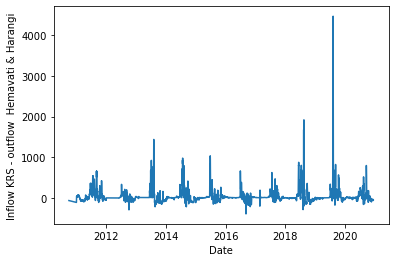

In [13]:
##Check if outflow upstream reservoirs is equal to inflow KRS 
plt.plot(KRS_reservoir['nat_inflow_KRS'])
plt.ylabel('Inflow KRS - outflow  Hemavati & Harangi')
plt.xlabel('Date')
# plt.ylim(-50,100)

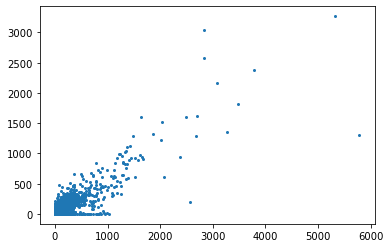

In [15]:
plt.plot(KRS_reservoir['Inflow_KRS'],KRS_reservoir['Outflow_Harangi']+KRS_reservoir['Outflow_Hemavathi'], 'o', markersize=2)

Text(0.5, 0, 'Year')

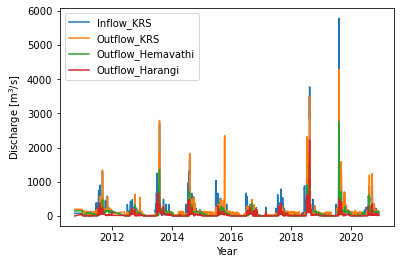

In [14]:
plt.plot(KRS_reservoir['Inflow_KRS'],label='Inflow_KRS')
plt.plot(KRS_reservoir['Outflow_KRS'],label='Outflow_KRS')
plt.plot(KRS_reservoir['Outflow_Hemavathi'],label='Outflow_Hemavathi')
plt.plot(KRS_reservoir['Outflow_Harangi'],label='Outflow_Harangi')
plt.legend(loc='best')
plt.ylabel('Discharge [m$^3$/s]')
plt.xlabel('Year')

In [5]:
#read merra-2 data
weather_pop = pd.read_csv(datapath / 'Weather' / 'population_weighted.csv', index_col=0, parse_dates=True, skiprows=2)
weather_area = pd.read_csv(datapath / 'Weather' / 'land_area_weighted.csv', index_col=0, parse_dates=True, skiprows=2)

In [6]:
#read csv data derived from satellite data (GPM) via Google Earth Engine
rain = pd.DataFrame(index = pd.date_range(pd.to_datetime('01-01-2010 00:00', dayfirst=True), pd.to_datetime('01-12-2019 00:00', dayfirst=True), freq='MS'), columns=reservoirs)

rain.loc[:, 'Kabini'] = pd.to_numeric(pd.read_csv(datapath / 'Weather' / 'sum_precip_monthly_Kabini.csv').precip, errors='coerce').values
rain.loc[:, 'Harangi'] = pd.to_numeric(pd.read_csv(datapath / 'Weather' / 'sum_precip_monthly_Harangi.csv').precip, errors='coerce').values
rain.loc[:, 'Hemavathi'] = pd.to_numeric(pd.read_csv(datapath / 'Weather' / 'sum_precip_monthly_Hemavathi.csv').precip, errors='coerce').values
# rain.loc[:, 'KRS'] = 

In [7]:
weather_area

,precipitation,temperature,irradiance_surface,irradiance_toa,snowfall,snow_mass,cloud_cover,air_density
time,,,,,,,,
1980-01-01 00:00:00,0.0000,14.386,0.0000,0.0000,0,0,0.2858,1.1314
1980-01-01 01:00:00,0.0000,14.591,30.7860,69.0649,0,0,0.2686,1.1338
1980-01-01 02:00:00,0.0000,17.109,217.6317,360.6971,0,0,0.2150,1.1333
1980-01-01 03:00:00,0.0000,20.594,455.4919,639.6638,0,0,0.1574,1.1232
1980-01-01 04:00:00,0.0000,24.465,650.9102,865.5091,0,0,0.1561,1.1102
...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,0.0026,20.063,0.0000,0.0000,0,0,0.3933,1.1126
2019-12-31 20:00:00,0.0037,19.670,0.0000,0.0000,0,0,0.3860,1.1135
2019-12-31 21:00:00,0.0032,19.385,0.0000,0.0000,0,0,0.3853,1.1143


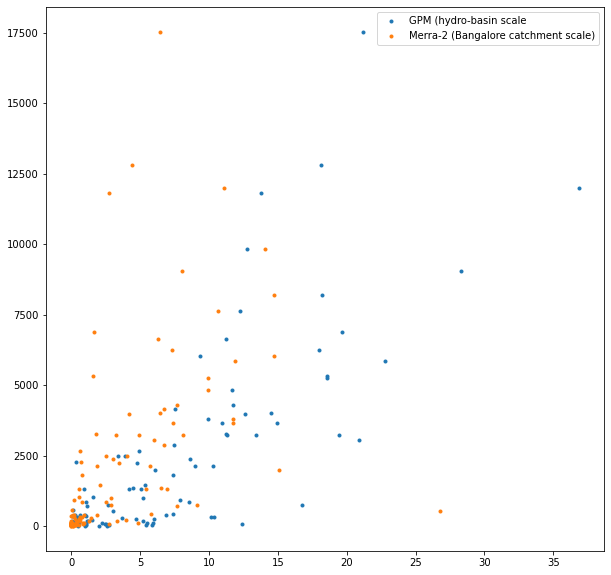

In [8]:
res = 'Hemavathi'
plt.figure(figsize=(10,10))
y_ =  reservoir_data[res].copy().resample('MS').sum() 
y_ = y_.loc[y_.index.isin(rain.index), 'Inflow']
x_ = rain.loc[rain.index.isin(y_.index), res]*(11100*11100)/2885180049*24
x__ = weather_area.copy().resample('D').sum()
x__ = x__.loc[x__.index.isin(y_.index), 'precipitation']

plt.plot(x_, y_, '.', label='GPM (hydro-basin scale)')
plt.plot(x__, y_, '.', label='Merra-2 (Bangalore catchment scale)')
plt.legend()

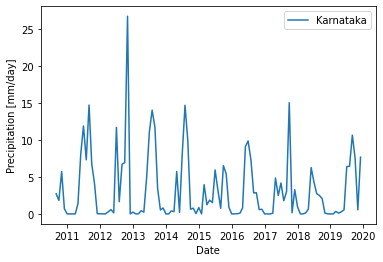

In [9]:
plt.plot(x__, label='Karnataka')
plt.ylabel('Precipitation [mm/day]')
plt.xlabel('Date')
plt.legend()

In [58]:
check = pd.DataFrame(index = x_.index, columns = ['Inflow', 'Rain_old', 'Rain_new'])
check.loc[:, 'Inflow'] = y_
check.loc[:, 'Rain_old'] = x__
check.loc[:, 'Rain_new'] = x_

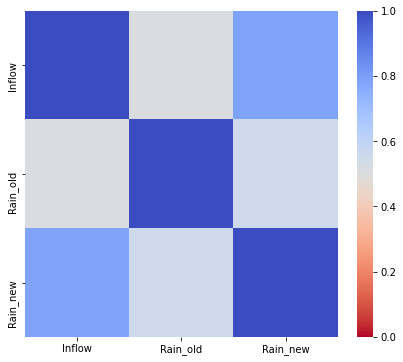

In [59]:
fig, ax = plt.subplots(figsize=(7,6))
sns.heatmap(check.corr(), cmap='coolwarm_r', ax=ax, vmin=0, vmax=1)

## Population
The United Nations - World Population Prospects for Bengalore is used for the histrocial but also futur population count.
The box below shows that with the current intake of 1445 m/l/d (source: introduction video of Hackathon) divided by the population of 2021, 
a water usage of 113 l/capita/day is used.

The ministry of Housing and Urban affairs sets as benchmark a 135 l/capita/day as water demand for urban areas. The benchmark is the aim for water used in aspect with future prospects and connectivities to water supply. Therefore a waterdemand of 135 l/capita/day is used.  
https://journalsofindia.com/per-capita-water-availability/



Average water usage based on current intake:  113.20015667841754


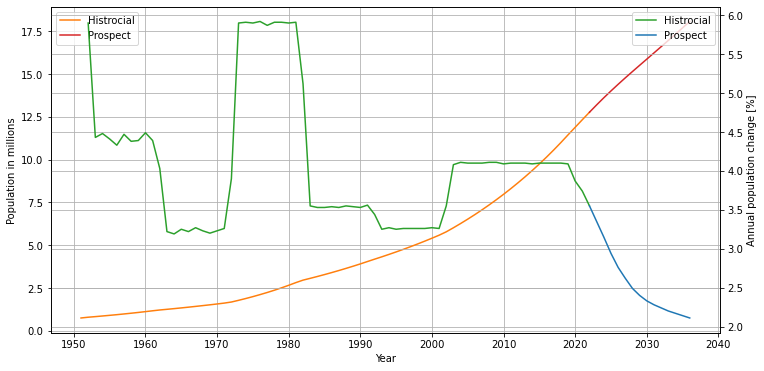

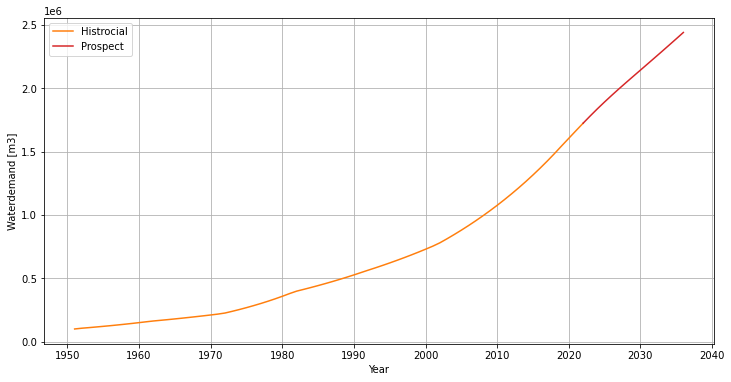

In [60]:
#read population
population = pd.read_csv(datapath/'Bangalore-population-2021-07-12.csv', skiprows=15, index_col='date')
population.index = pd.to_datetime(population.index,  format='%m/%d/%Y')#.tz_localize('GMT')

#print water usage based on provided information in the introduction ivdeo of the Hackathon
print('Average water usage based on current intake: ', 1445*1e6/float(population.loc['2021', ' Population']))

#plot population and annual growth
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(population.loc[:'2021', ' Population']/1e6,color='C1', label='Histrocial')
ax1.plot(population.loc['2021':, ' Population']/1e6,color='C3', label='Prospect')
ax1.set_ylabel('Population in millions')
# ax1.tick_params(axis='x', rotation=22.5)
ax1.set_xlabel('Year')
ax1.grid()
ax1.legend()
ax1.legend(bbox_to_anchor=(0, 1), loc='upper left')

ax2 = ax1.twinx()  #  second axes that shares the same x-axis
ax2.plot(population.loc[:'2021', ' Annual Change'],color='C2', label='Histrocial')
ax2.plot(population.loc['2021':, ' Annual Change'],color='C0', label='Prospect')
ax2.set_ylabel('Annual population change [%]')#'Chlorideconcentratie (mg/l)')
ax2.grid()
ax2.legend()
ax2.legend(bbox_to_anchor=(1, 1),loc='upper right')

#plot drinking water use
plt.figure(figsize=(12,6))
plt.plot(population.loc[:'2021', ' Population']*0.135,color='C1', label='Histrocial')
plt.plot(population.loc['2021':, ' Population']*0.135,color='C3', label='Prospect')
plt.ylabel('Waterdemand [m3]')
# ax1.tick_params(axis='x', rotation=22.5)
plt.xlabel('Year')
plt.grid()
plt.legend()


## Storage - Area relation
The reservoir storage is estimated with the use of remote sensing satellite Sentinel-2 of ESA.
By calculating and using the NDWI, which is an index to discriminated water from land, the reservour area is calculated for all the availbale moments from 2017 until present.

The calculated reservoir areas are selected for the moments when no clouds are present. This is then related to the storage area, so we can obtain historical reservoir areas. This is needed to calculate reservoir evaporation for the historical timeseries from irradiance and area.

In [61]:
def read_reservoir_Area_data(point):
    Area = pd.read_csv(datapath / 'ReservoirArea' / ('cloudmasked_allpixel_area'+str(point)+'.csv'), index_col='date')
    name= point_to_reservoir[point]
    Area.index = (pd.to_datetime(Area.index,  format='%Y-%m-%d'))
    Area = Area.loc[:, ['Water_pixels', 'perc cloud']]
    for c in Area.columns:
        Area.loc[:, c] = pd.to_numeric(Area.loc[:,c], errors='coerce')
        
    Area.columns = ['Area', 'Cloud_percentage']
  
    return Area

#read area
points = [0,1,2,3]
point_to_reservoir = ['Harangi', 'KRS' , 'Hemavathi', 'Kabini']
reservoir_Area_data = {point_to_reservoir[r]: read_reservoir_Area_data(r) for r in points}


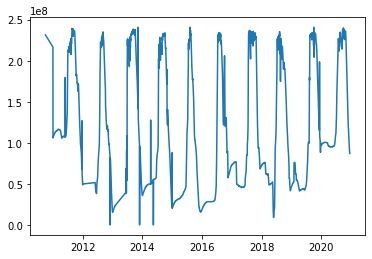

In [62]:
res = 'Harangi'
Storage = reservoir_data[res]['Storage'].copy()
plt.plot(Storage)

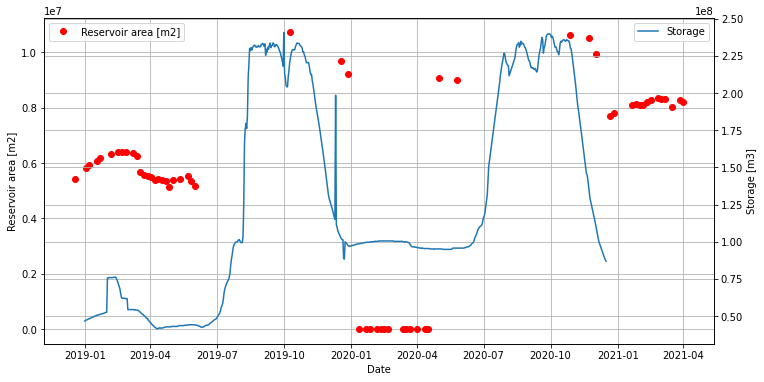

In [63]:
reservoir_Area_data[res].loc['2020-01': '2020-04', 'Area'] = 0
fig, ax1 = plt.subplots(figsize=(12,6))
ar = reservoir_Area_data['Harangi']
ar=ar[ar.Cloud_percentage>0.95]
ax1.set_ylabel('Reservoir area [m2]')
ax1.set_xlabel('Date')
ax1.plot(ar.Area,  'ro', label='Reservoir area [m2]')
ax1.grid()
ax1.legend()
ax1.legend(bbox_to_anchor=(0, 1), loc='upper left')

ax2 = ax1.twinx()  #  second axes that shares the same x-axis
ax2.plot(reservoir_data[res]['Storage'].loc['2019':], label='Storage')
ax2.set_ylabel('Storage [m3]')#'Chlorideconcentratie (mg/l)')
ax2.grid()
ax2.legend()
ax2.legend(bbox_to_anchor=(1, 1),loc='upper right')

In [64]:
# reservoir_Area_data[res].loc['2020-01': '2020-04', 'Area']=0
# reservoir_Area_data[res].loc['2020-01': '2020-04', 'Area']
# plt.plot(reservoir_Area_data[res].loc[:, 'Area'])
# print(reservoir_Area_data[res]['Area'].loc[reservoir_Area_data[res]['Area']!=0].index)
print(reservoir_data[res]['Storage'])




2010-09-30    2.313486e+08
2010-10-01    2.311886e+08
2010-10-02    2.310285e+08
2010-10-03    2.308685e+08
2010-10-04    2.307084e+08
                  ...     
2020-12-12    9.174658e+07
2020-12-13    9.033074e+07
2020-12-14    8.891490e+07
2020-12-15    8.778222e+07
2020-12-16    8.693272e+07
Freq: D, Name: Storage, Length: 3731, dtype: float64


,a,b
Reservoir,,
Harangi,0.035461,4.221792e+06
KRS,0.054534,3.059061e+07
Hemavathi,0.015864,3.421581e+06
Kabini,0.081778,1.611979e+07


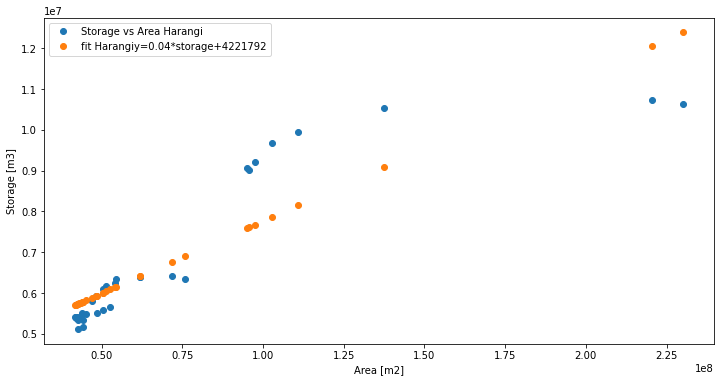

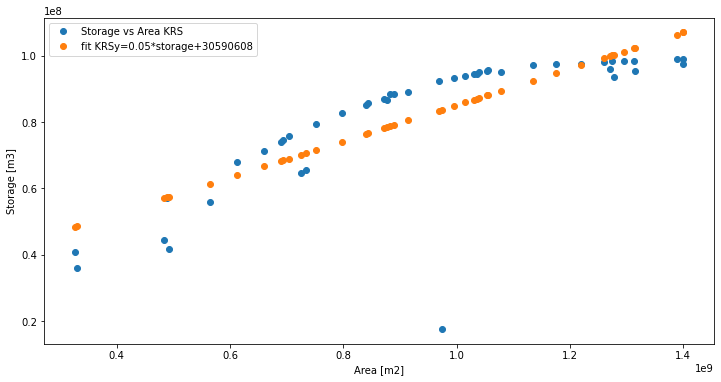

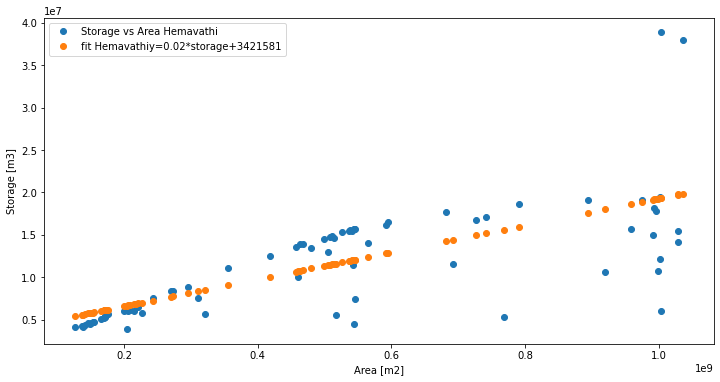

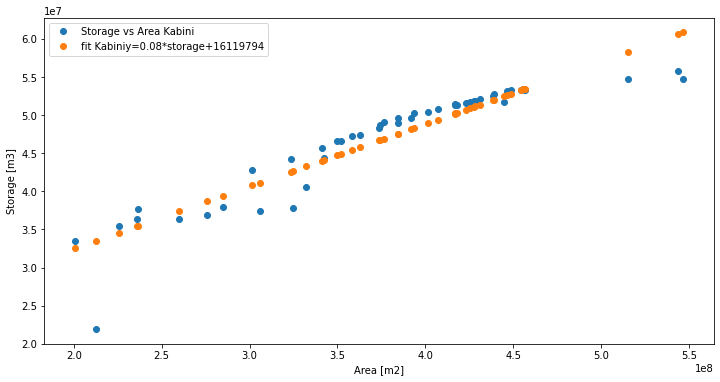

In [65]:
reservoirs = ['Harangi', 'KRS' , 'Hemavathi', 'Kabini']

df_polyfit = pd.DataFrame( columns=['Reservoir', 'a', 'b'])

for res in reservoirs:
    ar = reservoir_Area_data[res]
    ar=ar[ar.Cloud_percentage>0.95]
    index_ar = ar['Area'].loc[ar['Area']!=0].index
    stor = reservoir_data[res]['Storage'].loc[reservoir_data[res]['Storage'].index.isin(index_ar)]
    area = ar['Area'].loc[ar['Area'].index.isin(stor.index.unique())]
    area = area[~area.index.duplicated(keep='first')]
    
    fig, ax1 = plt.subplots(figsize=(12,6))
    plt.plot(stor, area, 'o', label='Storage vs Area '+res)
    m, b = np.polyfit(stor, area, 1)
    plt.plot(stor, m*stor + b, 'o', label='fit '+res+'y='+str(round(m,2))+'*storage+'+str(int(b)))
    plt.legend()
    plt.xlabel('Area [m2]')
    plt.ylabel('Storage [m3]')
    
    #fill polyfit
    df2 = pd.DataFrame( [[res, m,b]], columns=['Reservoir', 'a', 'b'])
    df_polyfit=df_polyfit.append(df2, ignore_index=True)

df_polyfit=df_polyfit.set_index('Reservoir')
df_polyfit

## Evaporation per reservoir

## evaporation
Analysis to determain evaporation based on irradiance and reservoir surface area (which is determined above)

In [66]:
volume_E = pd.DataFrame([])

reservoirs = ['Harangi', 'KRS' , 'Hemavathi', 'Kabini']

for res in reservoirs:
    df_area = reservoir_data[res]['Storage'] * df_polyfit.loc[res,'a'] +df_polyfit.loc[res,'b']
    irradiance_day = weather_area.irradiance_surface.resample('D').mean()*3600*24/1000
    E = irradiance_day * 1.97/100/100 #mm/cm2/d/kj naar mm/m2/d/kj  #uitgangspunt 25 graden zie: https://edepot.wur.nl/5284#:~:text=Het%20verdampen%20van%20water%20kost,Dat%20is%20een%20grote%20hoeveelheid.&text=Voor%20verdamping%20is%20dan%20ook,dan%20de%2030%20MJ%2Fm2.
    vol_E = df_area.loc['2010-10':'2019'] * E.loc['2010-10':]/1000 #mm naar m
    volume_E[res] = vol_E

volume_E

,Harangi,KRS,Hemavathi,Kabini
2010-10-01,50805.502761,416820.583162,76780.768393,230653.045985
2010-10-02,47537.234515,390161.446111,71870.081095,215898.606843
2010-10-03,48920.276192,401671.912926,73990.460910,222265.676589
2010-10-04,46023.607461,378037.981318,69637.021786,209185.617678
2010-10-05,49440.279824,406263.683835,74836.460975,224801.827288
...,...,...,...,...
2019-12-27,28351.982776,368095.059568,47774.309434,188806.741833
2019-12-28,27286.892111,355876.820539,45744.849497,182591.659058
2019-12-29,28629.486264,374164.429913,47639.092681,192086.081977
2019-12-30,27890.433005,365264.952685,46093.803414,187457.286603


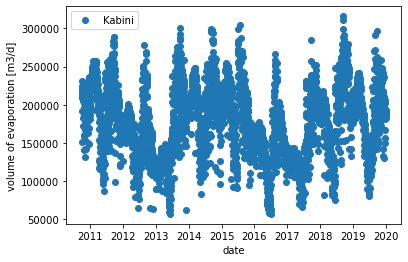

In [67]:
## evap in m3 per reservoir

#j/s/m2 
# plt.plot(volume_E.loc['2010':], 'o')

plt.plot(volume_E.loc['2010':, res], 'o', label=res)
plt.xlabel('date')
plt.ylabel('volume of evaporation [m3/d]')
plt.legend()
# plt.plot(df_area)

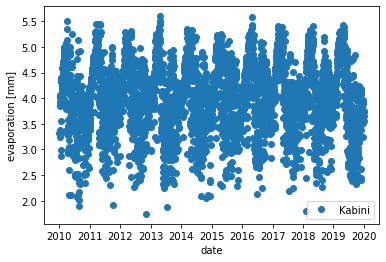

In [68]:
## evap in mm

plt.plot(E.loc['2010':], 'o', label=res)
plt.xlabel('date')
plt.ylabel('evaporation [mm]')
plt.legend()
# plt.plot(df_area)

## Conceptual bucket model

In [87]:
#read Quantile regression output data as inflow data for the reservoirs
def read_reservoir_forecast_monthly_data(point):
    name= point_to_reservoir[point]
    forc = pd.read_csv( 'Forecasts/Monthly/Online training/' +(str(name)+'.csv'), index_col=[0], parse_dates=True)
    forc.index = (pd.to_datetime(forc.index,  format='%Y-%m-%d'))
   
    for c in forc.columns:
        forc.loc[:, c] = pd.to_numeric(forc.loc[:,c], errors='coerce')
    return forc

#read forecast
points = [0,1,2]
point_to_reservoir = ['Harangi' , 'Hemavathi', 'Kabini']
forecast_monthly_data = {point_to_reservoir[r]: read_reservoir_forecast_monthly_data(r) for r in points}
# forecast_monthly_data

In [254]:
res='Harangi'
year = '2018'
month = '4'
month_end = '6'
columns = ['m1 q0.05', 'm2 q0.05', 'm3 q0.05', 'm1 q0.95', 'm2 q0.95', 'm3 q0.95', 'm1 q0.5', 'm2 q0.5', 'm3 q0.5']

initial_reservoir_volume = float(reservoir_data[res]['Storage'].max())*0.5
max_reservoir_volume = float(reservoir_data[res]['Storage'].max())

#setting variables
drinkingwater = float(population.loc[year, ' Population']*0.135*30*1.4)  ## voor de eenvoud 30 dagen per maand * 1.4 vanwege lekverliezen
irrigation= drinkingwater
volume_E_month = volume_E.loc[year+'-'+month : year+'-'+month_end, res].resample('M').sum()
volume_E_month.index=Reservoir_balance.index
Reservoir_balance = forecast_monthly_data[res].loc[year+'-'+month : year+'-'+month_end, columns].copy()
Reservoir_balance=Reservoir_balance*3600*24*30
Reservoir_balance.loc[:, Reservoir_balance.columns[:-1]]= Reservoir_balance.loc[:, Reservoir_balance.columns[:-1]].subtract(0.3*drinkingwater)  #-Reservoir_balance['drinkingwater']

# Reservoir_balance[Reservoir_balance.columns[:3]] = 
Reservoir_balance['volume q0.05'] = 0
Reservoir_balance['volume q0.5'] = 0
Reservoir_balance['volume q0.95'] = 0
Reservoir_balance['volume q0.05_irri'] = 0
Reservoir_balance['volume q0.5_irri'] = 0
Reservoir_balance['volume q0.95_irri'] = 0

for maand in range(len(volume_E_month)):
    Reservoir_balance[Reservoir_balance.columns[0+maand]]=Reservoir_balance[Reservoir_balance.columns[0+maand]].subtract(volume_E_month[maand])
    Reservoir_balance[Reservoir_balance.columns[3+maand]]=Reservoir_balance[Reservoir_balance.columns[3+maand]].subtract(volume_E_month[maand])
    Reservoir_balance[Reservoir_balance.columns[6+maand]]=Reservoir_balance[Reservoir_balance.columns[6+maand]].subtract(volume_E_month[maand])
    if maand == 0:
        Reservoir_balance['volume q0.05'].iloc[maand] = min(max_reservoir_volume,Reservoir_balance[Reservoir_balance.columns[0+maand]].iloc[0]+initial_reservoir_volume)
        Reservoir_balance['volume q0.5'].iloc[maand] = min(max_reservoir_volume,Reservoir_balance[Reservoir_balance.columns[3+maand]].iloc[0]+initial_reservoir_volume)
        Reservoir_balance['volume q0.95'].iloc[maand] = min(max_reservoir_volume,Reservoir_balance[Reservoir_balance.columns[6+maand]].iloc[0]+initial_reservoir_volume)
        Reservoir_balance['volume q0.05_irri'].iloc[maand] = min(max_reservoir_volume,Reservoir_balance[Reservoir_balance.columns[0+maand]].iloc[0]+initial_reservoir_volume)
        Reservoir_balance['volume q0.5_irri'].iloc[maand] = min(max_reservoir_volume,Reservoir_balance[Reservoir_balance.columns[3+maand]].iloc[0]+initial_reservoir_volume)
        Reservoir_balance['volume q0.95_irri'].iloc[maand] = min(max_reservoir_volume,Reservoir_balance[Reservoir_balance.columns[6+maand]].iloc[0]+initial_reservoir_volume)
    else:
    
        Reservoir_balance['volume q0.05'].iloc[maand] = min(max_reservoir_volume, Reservoir_balance['volume q0.05'].iloc[maand-1]+Reservoir_balance[Reservoir_balance.columns[0+maand]].iloc[0])
        Reservoir_balance['volume q0.5'].iloc[maand] = min(max_reservoir_volume, Reservoir_balance['volume q0.5'].iloc[maand-1]+Reservoir_balance[Reservoir_balance.columns[0+maand]].iloc[0])
        Reservoir_balance['volume q0.95'].iloc[maand] = min(max_reservoir_volume, Reservoir_balance['volume q0.95'].iloc[maand-1]+Reservoir_balance[Reservoir_balance.columns[0+maand]].iloc[0])
        Reservoir_balance['volume q0.05_irri'].iloc[maand] = min(max_reservoir_volume, Reservoir_balance['volume q0.05_irri'].iloc[maand-1]+Reservoir_balance[Reservoir_balance.columns[0+maand]].iloc[0]-irrigation)
        Reservoir_balance['volume q0.5_irri'].iloc[maand] = min(max_reservoir_volume, Reservoir_balance['volume q0.5_irri'].iloc[maand-1]+Reservoir_balance[Reservoir_balance.columns[0+maand]].iloc[0]-irrigation)
        Reservoir_balance['volume q0.95_irri'].iloc[maand] = min(max_reservoir_volume, Reservoir_balance['volume q0.95_irri'].iloc[maand-1]+Reservoir_balance[Reservoir_balance.columns[0+maand]].iloc[0]-irrigation)

print(Reservoir_balance.head())




Reservoir_balance.head()

                m1 q0.05      m2 q0.05      m3 q0.05      m1 q0.95  \
2018-04-01  9.115269e+06  4.871902e+07  1.065381e+08 -5.686345e+07   
2018-05-01  1.188186e+08  2.509254e+08  3.359395e+08 -5.205191e+07   
2018-06-01  2.193948e+08  3.861620e+08  4.711422e+08  5.551635e+06   

                m2 q0.95      m3 q0.95       m1 q0.5       m2 q0.5  \
2018-04-01 -2.746726e+07  8.907111e+06 -2.788411e+07 -1.460632e+07   
2018-05-01  1.753799e+07  1.065592e+08 -4.615383e+06  7.170821e+07   
2018-06-01  9.662466e+07  1.692188e+08  3.524817e+07  2.031070e+08   

                 m3 q0.5  volume q0.05   volume q0.5  volume q0.95  \
2018-04-01  8.673892e+07  1.294619e+08  6.348315e+07  9.246249e+07   
2018-05-01  2.542223e+08  1.781809e+08  1.122022e+08  1.411815e+08   
2018-06-01  2.942203e+08  2.406932e+08  2.187403e+08  2.406932e+08   

            volume q0.05_irri  volume q0.5_irri  volume q0.95_irri  
2018-04-01       1.294619e+08      6.348315e+07       9.246249e+07  
2018-05-01       1.

/opt/tljh/user/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,m1 q0.05,m2 q0.05,m3 q0.05,m1 q0.95,m2 q0.95,m3 q0.95,m1 q0.5,m2 q0.5,m3 q0.5,volume q0.05,volume q0.5,volume q0.95,volume q0.05_irri,volume q0.5_irri,volume q0.95_irri
2018-04-01,9.115269e+06,4.871902e+07,1.065381e+08,-5.686345e+07,-2.746726e+07,8.907111e+06,-2.788411e+07,-1.460632e+07,8.673892e+07,1.294619e+08,6.348315e+07,9.246249e+07,1.294619e+08,6.348315e+07,9.246249e+07
2018-05-01,1.188186e+08,2.509254e+08,3.359395e+08,-5.205191e+07,1.753799e+07,1.065592e+08,-4.615383e+06,7.170821e+07,2.542223e+08,1.781809e+08,1.122022e+08,1.411815e+08,1.133161e+08,4.733737e+07,7.631671e+07
2018-06-01,2.193948e+08,3.861620e+08,4.711422e+08,5.551635e+06,9.662466e+07,1.692188e+08,3.524817e+07,2.031070e+08,2.942203e+08,2.406932e+08,2.187403e+08,2.406932e+08,1.549894e+08,8.901072e+07,1.179901e+08


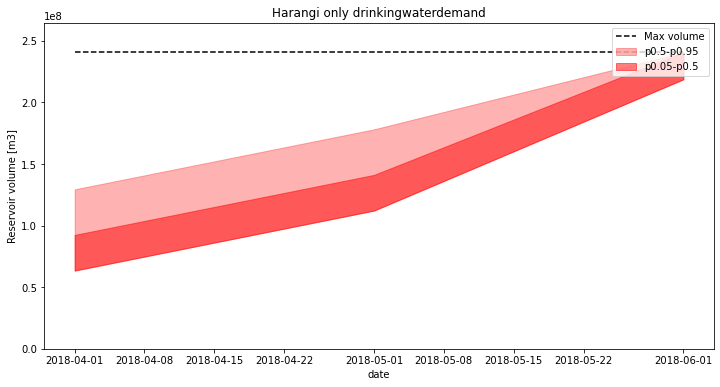

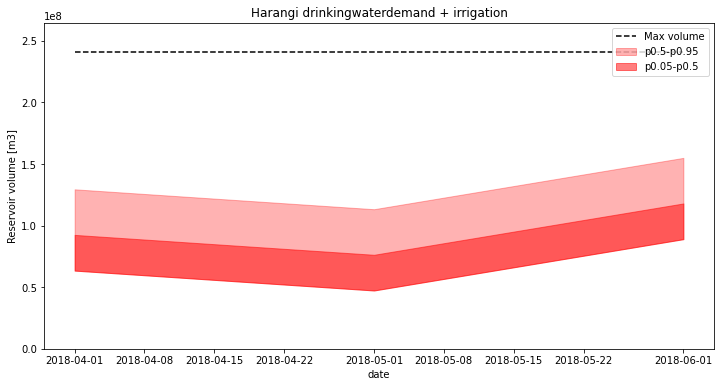

In [255]:
plt.figure(figsize=(12,6))
plt.title(res+' only drinkingwaterdemand')
plt.hlines(int(reservoir_data[res]['Storage'].max()), xmin=Reservoir_balance['volume q0.95'].index[0],xmax=Reservoir_balance['volume q0.95'].index[-1], linestyles='dashed', label='Max volume')
plt.fill_between(Reservoir_balance.index, Reservoir_balance['volume q0.5'], Reservoir_balance['volume q0.05'], color='red', alpha=0.3, label='p0.5-p0.95')
plt.fill_between(Reservoir_balance.index, Reservoir_balance['volume q0.5'], Reservoir_balance['volume q0.95'], color='red', alpha=0.5, label='p0.05-p0.5')
# plt.plot(Reservoir_balance['volume q0.05'], label='Volume p0.05')
# plt.plot(Reservoir_balance['volume q0.5'], label='Volume p0.5')
# plt.plot(Reservoir_balance['volume q0.95'], label='Volume p0.95')
plt.ylim(0, int(reservoir_data[res]['Storage'].max())*1.1)
plt.xlabel('date')
plt.ylabel('Reservoir volume [m3]')

plt.legend()

plt.figure(figsize=(12,6))
plt.title(res+' drinkingwaterdemand + irrigation')
plt.hlines(int(reservoir_data[res]['Storage'].max()), xmin=Reservoir_balance['volume q0.95_irri'].index[0],xmax=Reservoir_balance['volume q0.95_irri'].index[-1], linestyles='dashed', label='Max volume')
plt.fill_between(Reservoir_balance.index, Reservoir_balance['volume q0.5_irri'], Reservoir_balance['volume q0.05_irri'], color='red', alpha=0.3, label='p0.5-p0.95')
plt.fill_between(Reservoir_balance.index, Reservoir_balance['volume q0.5_irri'], Reservoir_balance['volume q0.95_irri'], color='red', alpha=0.5, label='p0.05-p0.5')
# plt.plot(Reservoir_balance['volume q0.05'], label='Volume p0.05')
# plt.plot(Reservoir_balance['volume q0.5'], label='Volume p0.5')
# plt.plot(Reservoir_balance['volume q0.95'], label='Volume p0.95')
plt.ylim(0, int(reservoir_data[res]['Storage'].max())*1.1)
plt.xlabel('date')
plt.ylabel('Reservoir volume [m3]')

plt.legend()

481261.5


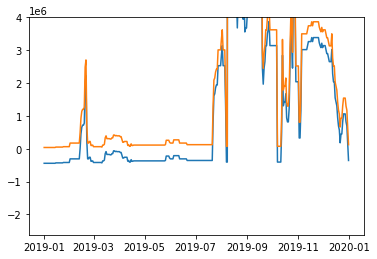

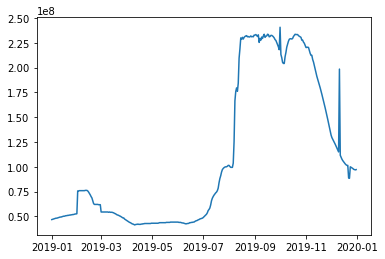

In [195]:
plt.plot(reservoir_data[res].loc['2019','Outflow']*3600*24 - float(population.loc[year, ' Population']*0.135*0.3))
plt.plot(reservoir_data[res].loc['2019','Outflow']*3600*24)
plt.ylim(top=0.4e7)
plt.figure()
plt.plot(reservoir_data[res].loc['2019','Storage'])

print(float(population.loc[year, ' Population']*0.135*0.3))

## Precip

In [12]:
Precip_daily = pd.read_csv(datapath / 'Weather' / ('sum_precip_daily.csv'), index_col='date')
Precip_daily.index = (pd.to_datetime(Precip_daily.index,  format='%m/%d/%Y'))
Precip_daily = Precip_daily.loc[:, ['Hemavathi','Harangi','Kabini']]  

for c in Precip_daily.columns:
    Precip_daily.loc[:, c] = pd.to_numeric(Precip_daily.loc[:,c], errors='coerce')

Precip_daily.columns = ['Hemavathi','Harangi','Kabini']

print( Precip_daily)


             Hemavathi     Harangi      Kabini
date                                          
2010-01-01    0.000000    0.000000    1.738972
2010-01-02    0.000000    0.000000    0.387697
2010-01-03    0.000000    0.000000    0.000000
2010-01-04    0.000000    0.000000    0.000000
2010-01-05    0.000000    0.000000    0.000000
...                ...         ...         ...
2019-12-26  111.302427  104.374329  136.947452
2019-12-27    0.000000    0.000000   57.052972
2019-12-28   15.444707    1.271699    0.000000
2019-12-29  149.089789    7.072589    0.000000
2019-12-30    0.000000    0.445748    0.000000

[3651 rows x 3 columns]


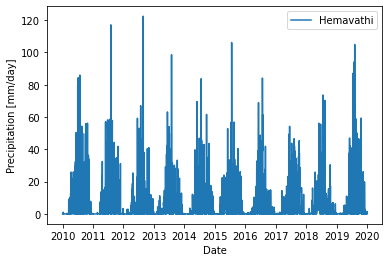

In [75]:
plt.plot(Precip_daily.Hemavathi*5500*5500/2885180049, label='Hemavathi')
plt.ylabel('Precipitation [mm/day]')
plt.xlabel('Date')
plt.legend()

In [71]:
Precip_daily.Hemavathi.iloc[0:10]

date
2010-01-01      0.000000
2010-01-02      0.000000
2010-01-03      0.000000
2010-01-04      0.000000
2010-01-05      0.000000
2010-01-06      0.000000
2010-01-07      0.000000
2010-01-08      0.000000
2010-01-09      0.000000
2010-01-10    102.776803
Name: Hemavathi, dtype: float64

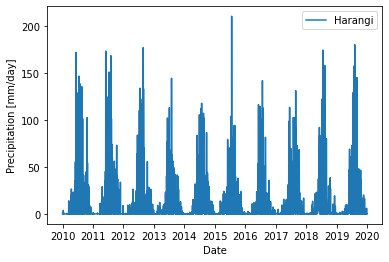

In [41]:
plt.plot(Precip_daily.Harangi*5500*5500/525693758, label='Harangi')
plt.ylabel('Precipitation [mm/day]')
plt.xlabel('Date')
plt.legend()


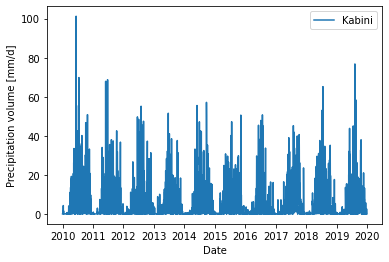

In [40]:
plt.plot(Precip_daily.Kabini*5500*5500/7074490388, label='Kabini')
plt.ylabel('Precipitation volume [mm/d]')
plt.xlabel('Date')
plt.legend()

# Harangi

In [96]:
for y in range(10):
    year_out = str(2011+y)
    #mean outflow reservoirs
    mean_outflow = float((reservoir_data[reservoirs[2]].loc[year_out, 'Outflow']+reservoir_data[reservoirs[3]].loc[year_out, 'Outflow']).mean())

    usage_per_capita = mean_outflow*3600*24*1000/float(population.loc[year_out, ' Population'])
    print(year_out, usage_per_capita, 'o') 
#     plt.plot(year_out, mean_outflow, 'o') 

2011 2482.553050779342 o
2012 1752.303079491501 o
2013 3485.740320734515 o
2014 1825.96941032804 o
2015 1735.3546552201942 o
2016 989.9626382094166 o
2017 849.429865465154 o
2018 2905.7690368313124 o
2019 1837.415393518806 o
2020 1173.5720824516698 o


In [98]:
mean_outflow*3600*24*1000/1e6
# float(population.loc[year_out, ' Population'])
# plt.plot(217)
1445*1e6/float(population.loc['2021', ' Population'])

113.20015667841754